In [1]:
from instacart_data import *
from instacart_net import *

import netpixi
from graph_tool import draw
import graph_tool_extras as gte

from graph_tool import centrality, clustering

import regression as reg

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import random as rd

Fazendo varredura no arquivo de pedidos...
Salvando dados dos pedidos dos usuários...
Carregando dados dos produtos dos pedidos...
Fazendo levantamento de dados sobre os produtos dos usuários...
Salvando dados dos produtos dos usuários...
Fazendo varredura no arquivo de produtos...
Fazendo levantamento de dados sobre os produtos...
Salvando dados dos produtos...


In [2]:
name = 'edges_less'

In [3]:
order_products = get_order_products()

Carregando dados dos produtos dos pedidos...


In [4]:
rd.seed(41)

filtered_order_products = {}
for order_id, products in order_products.items():
    if rd.random() > 0.9:
        filtered_order_products[order_id] = products
len(order_products), len(filtered_order_products)

(3346083, 334925)

In [5]:
edges = gen_edges_data(filtered_order_products, name)

Gerando dados das arestas...
29.0740%
55.9830%
83.9316%
Ordenando arestas por peso...
Salvando dados das arestas...


In [6]:
pd.Series(edges.values()).describe().round(2)

count    10129535.00
mean            4.95
std            27.92
min             2.00
25%             2.00
50%             2.00
75%             4.00
max         13226.00
dtype: float64

In [7]:
edges_weights = list(edges.values())
threshold = round(np.mean(edges_weights) + np.std(edges_weights), 0)
threshold

np.float64(33.0)

In [8]:
gen_edges_csv(name, edges, threshold)

148034 arestas geradas com o threshold de 33.0


In [9]:
g = gen_net(name)

In [10]:
layout = draw.sfdp_layout(g)

In [11]:
gte.move(g, layout)

In [12]:
g = gte.clean(g)

In [27]:
c = centrality.closeness(g, harmonic=True)
g.add_vp('closeness', c)
b, _ = centrality.betweenness(g)
g.add_vp('betweenness', b)
d = gte.total_degree(g)
g.add_vp('degree', d)
cc = clustering.local_clustering(g)
g.add_vp('clustering', cc)

In [28]:
gte.save(g, f'{name}.net.gz')

In [ ]:
r = netpixi.render(f'{name}.net.gz', infinite=True)

In [22]:
time.sleep(2.5)
r.vertex_default(size=4, bwidth=1)
r.edge_default(width=1)

In [17]:
data = from_net_to_dataframe(g)
data

,id,aisle,department,name,purchased_once,purchased_more_than_once,number_of_users_purchased,total_purchases,PRC,_x,_y,closeness,betweenness,degree,clustering
0,13176,fresh fruits,None,Bag of Organic Bananas,47063,18592,65655,394930,0.283177,1.259116,2.093685,0.821648,0.211976,0.646882,0.014912
1,21137,fresh fruits,None,Organic Strawberries,39871,21258,61129,275577,0.347756,1.260394,2.071252,0.749096,0.064636,0.503681,0.023859
2,47209,fresh fruits,None,Organic Hass Avocado,30047,14657,44704,220877,0.327868,1.261006,2.073246,0.721961,0.046808,0.450939,0.028698
3,24852,fresh fruits,None,Banana,57186,18939,76125,491291,0.248788,1.265953,1.996985,0.916391,0.520799,0.835011,0.008937
4,47766,fresh fruits,None,Organic Avocado,28478,15476,43954,184224,0.352095,1.257002,2.055372,0.677921,0.018846,0.364237,0.042883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,35112,canned fruit applesauce,None,Organic Mashups Strawberry Banana,82,113,195,625,0.579487,1.251551,2.319638,0.440316,0.000000,0.000150,0.000000
6652,15351,tea,None,Organic Unsweetened Green Tea,89,125,214,550,0.584112,1.178820,2.304780,0.440316,0.000000,0.000150,0.000000
6653,33109,yogurt,None,Greek Plain Whole Milk Yogurt,81,167,248,570,0.673387,1.262930,1.816014,0.472016,0.000000,0.000150,0.000000
6654,19087,oral hygiene,None,Wicked Fresh! Mouthwash - Cool Mountain Mint,174,553,727,1134,0.760660,1.059137,2.176374,0.366602,0.000000,0.000150,0.000000


In [18]:
independente = data['clustering']
dependente = data['PRC']
controle = np.log(data['degree'])

data_hipotese = pd.DataFrame({
    'dependente': dependente, 
    'independente': independente, 
    'controle': controle
})

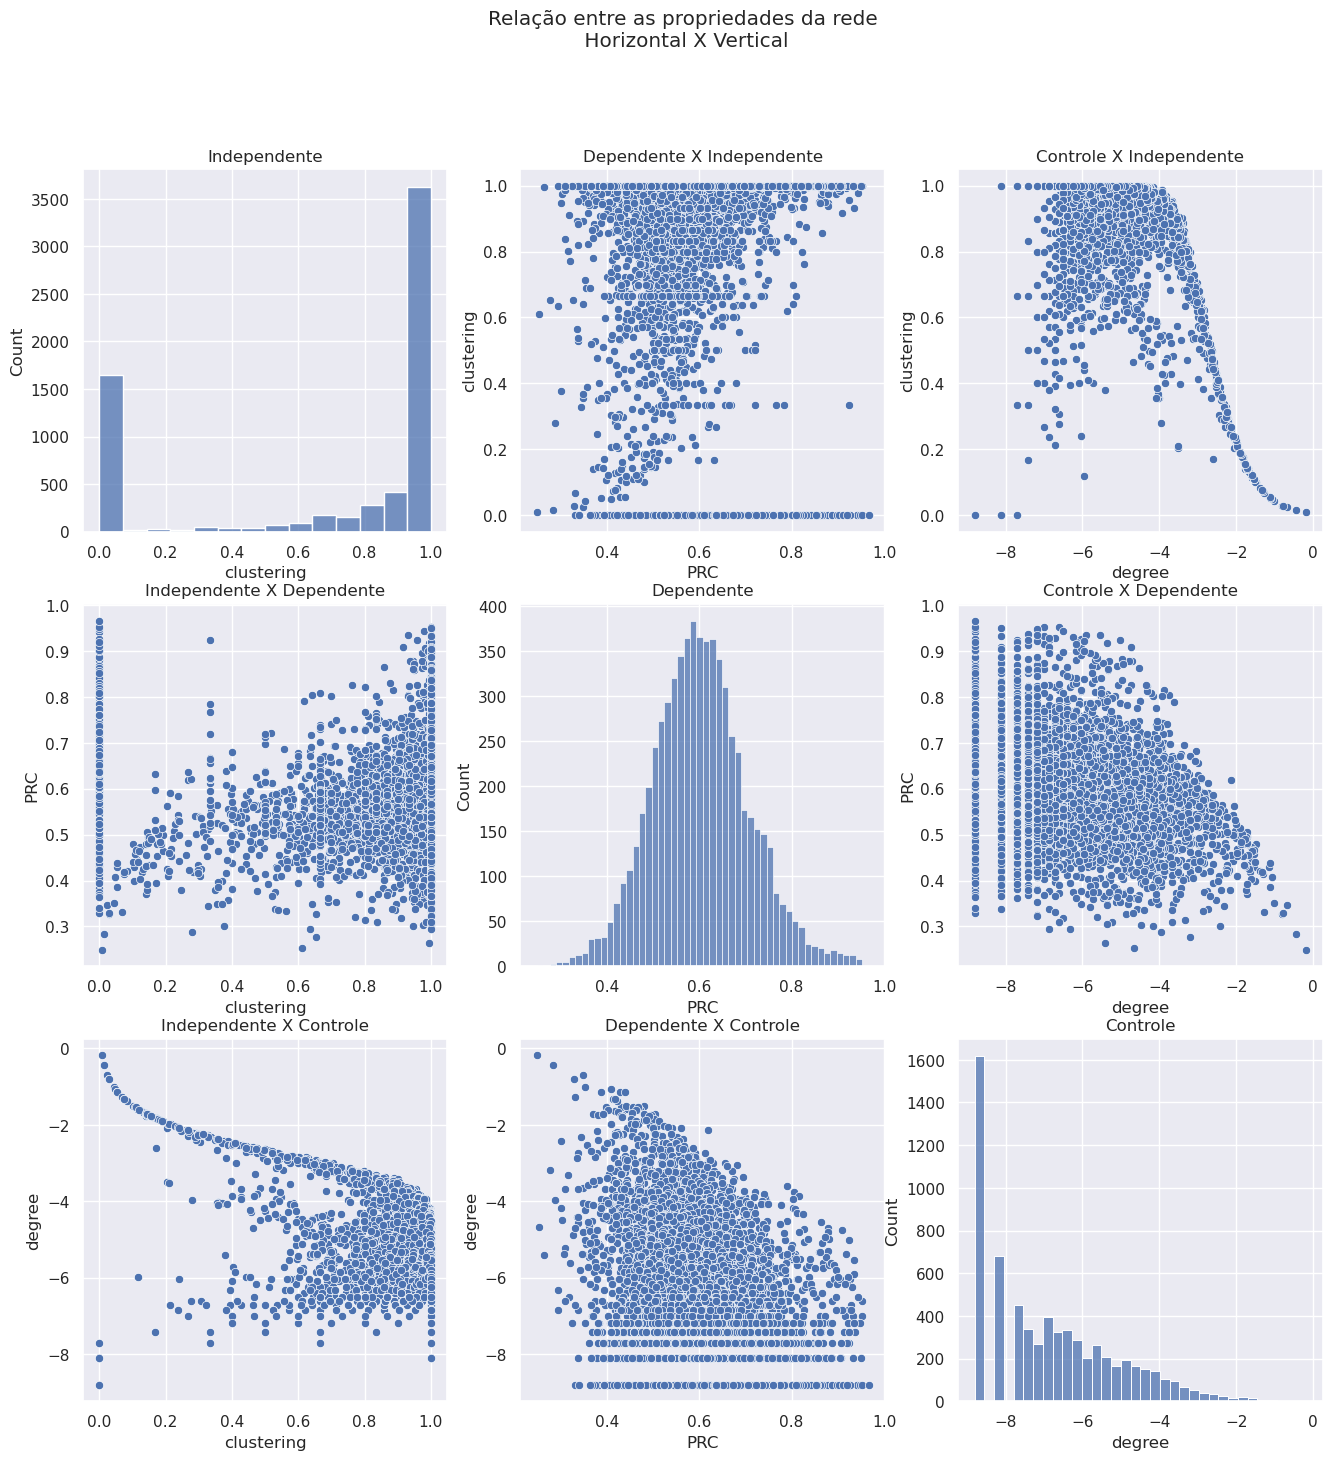

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

fig.suptitle("Relação entre as propriedades da rede\n Horizontal X Vertical")

sns.histplot(independente, ax=axes[0, 0]).set_title("Independente")
sns.scatterplot(x=dependente, y=independente, ax=axes[0, 1]).set_title("Dependente X Independente")
sns.scatterplot(x=controle, y=independente, ax=axes[0, 2]).set_title("Controle X Independente")

sns.scatterplot(x=independente, y=dependente, ax=axes[1, 0]).set_title("Independente X Dependente")
sns.histplot(dependente, ax=axes[1, 1]).set_title("Dependente")
sns.scatterplot(x=controle, y=dependente, ax=axes[1, 2]).set_title("Controle X Dependente")

sns.scatterplot(x=independente, y=controle, ax=axes[2, 0]).set_title("Independente X Controle")
sns.scatterplot(x=dependente, y=controle, ax=axes[2, 1]).set_title("Dependente X Controle")
sns.histplot(controle, ax=axes[2, 2]).set_title("Controle")

plt.show()

In [20]:
columns = ['independente', 'dependente', 'controle']
pd.DataFrame([[pearsonr(data_hipotese[j], data_hipotese[i]) for j in columns] for i in columns], columns=columns)

,independente,dependente,controle
0,1.0 (óbvio),-0.0686168468 ***,0.4718955203 ***
1,-0.0686168468 ***,1.0 (óbvio),-0.3032527666 ***
2,0.4718955203 ***,-0.3032527666 ***,1.0 (óbvio)


In [21]:
result = reg.linear(data=data_hipotese, formula='dependente ~ independente + controle') # dependente à esquerda!
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dependente   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     365.9
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          1.70e-151
Time:                        14:13:29   Log-Likelihood:                 5946.2
No. Observations:                6656   AIC:                        -1.189e+04
Df Residuals:                    6653   BIC:                        -1.187e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4430      0.007     64.167      0.000       0.429       0.456
independente     0.0238      0.003      7.260      0.000       0.017       0.030
controle        -0.0210      0.001    -26.402      0.000      -0.023      -0.019
==============================================================================
Omnibus:                      137.911   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.832
Skew:                           0.296   Prob(JB):                     2.66e-36
Kurtosis:                       3.489   Cond. No.                         43.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""